In [117]:
# Imports
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F


from sklearn.model_selection import train_test_split
from skimage.draw import line_aa
from torch.utils.data import DataLoader, Subset, TensorDataset

from torchsummary import summary
import torchvision as tv
import torchvision.transforms as T
import copy

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline as backend_inline

backend_inline.set_matplotlib_formats("svg")


#### Pytorch device specific configuration ###

# Pytorch Gpu Configuration for Cuda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Pytorch Gpu Configuration for directml(AMD GPU)
# import torch_directml

# device = torch_directml.device()

# Set default device
torch.set_default_device(device)

In [118]:
# Create the train data


# Create Gaussian blurs with varying widths and occluding bars
def create_Gaussian_blurs(nGauss=1000, imgSize=91):
    """
    Create a set of random occluding bars.
    Returns:
        images (torch.Tensor): Tensor containing the generated images.
    """
    # Create a grid of points
    # Initialize tensor containing Gaussian blur images
    images = torch.zeros(nGauss, 1, imgSize, imgSize)
    labels = torch.zeros(nGauss, 1)
    classes = ["Horiz.", "Vert."]
    for i in range(nGauss):
        # Create Gaussian blur
        G = np.random.randn(imgSize, imgSize) / 2

        # Add random bar randomly
        i1 = np.random.choice(np.arange(2, 28))
        i2 = np.random.choice(np.arange(2, 6))

        if np.random.randn() > 0:
            G[i1 : (i1 + i2*3),] = 1
            labels[i] = 0
        else:
            G[:, i1 : (i1 + i2*3)] = 1
            labels[i] = 1

        # Add to the tensor images
        images[i, :, :, :] = torch.tensor(G).view(1, imgSize, imgSize)
    return images, labels, classes


# Create Gaussian blur images
imgSize = 91
nGauss_train = 20000
nGauss_dev = 1000
train_images, train_labels, classes = create_Gaussian_blurs(nGauss_train, imgSize)
dev_images, dev_labels, classes = create_Gaussian_blurs(nGauss_dev, imgSize)

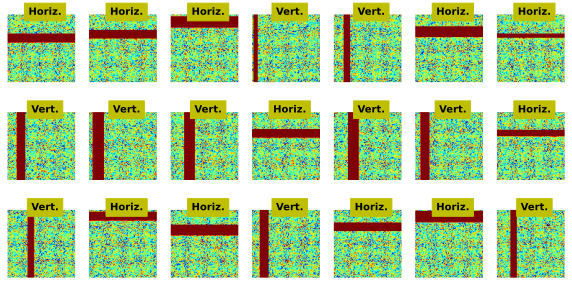

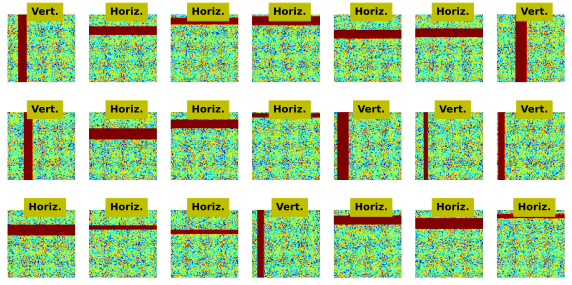

In [119]:
# visualize some train images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_train)
    label = train_labels[whichpic]
    im_class = classes[int(label[0])]
    G = np.squeeze(train_images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet", label=im_class)
    ax.text(
        50, 0, im_class, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

# visualize some dev images
fig, axs = plt.subplots(3, 7, figsize=(10, 5))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_dev)
    label = dev_labels[whichpic]
    im_class = classes[int(label[0])]
    G = np.squeeze(dev_images[whichpic, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet", label=im_class)
    ax.text(
        50, 0, im_class, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

In [120]:
# Test data initialization
# Create the train data


# Create Gaussian blurs with varying widths and occluding bars
def create_test_images(nGauss=1000, imgSize=91):
    """
    Create a set of random occluding bars.
    Returns:
        images (torch.Tensor): Tensor containing the generated images.
    """
    # Create a grid of points
    # Initialize tensor containing Gaussian blur images
    images = torch.zeros(nGauss, 1, imgSize, imgSize)
    for i in range(nGauss):
        # Create Gaussian blur
        # Add random bar randomly
        image = torch.zeros((91, 91))
        r0 = np.random.choice(np.arange(0, 91))
        c0 = np.random.choice(np.arange(0, 91))
        r1 = np.random.choice(np.arange(0, 91))
        c1 = np.random.choice(np.arange(0, 91))
        rr, cc, val = line_aa(0, c0, r1, 90)
        image[rr, cc] = torch.tensor(val * 255).float()
        image = image.reshape((1, 91, 91))
        images[i] = image
    return images


# Create Gaussian blur images
imgSize = 91
nGauss_test = 100
test_images = create_test_images(nGauss_test, imgSize).to(device)
print(test_images.shape)

torch.Size([100, 1, 91, 91])


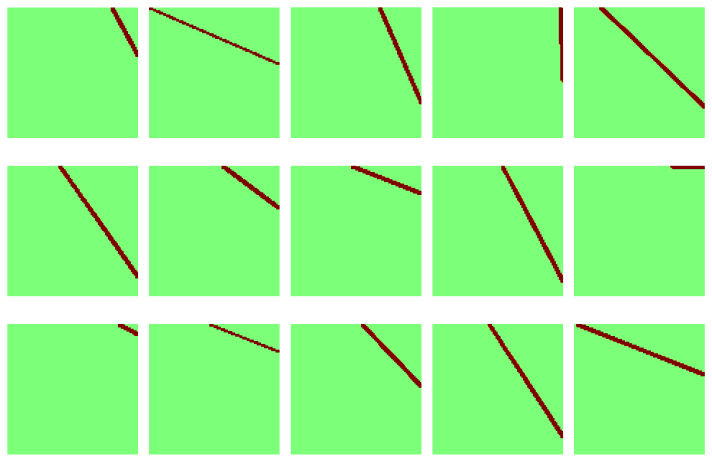

In [121]:
# visualize some test images
fig, axs = plt.subplots(3, 5, figsize=(10, 7))

for i, ax in enumerate(axs.flatten()):
    whichpic = np.random.randint(nGauss_test)
    G = np.squeeze(test_images[whichpic])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet")
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()
plt.show()

In [122]:
print(dev_images.shape,dev_labels.shape, train_images.shape, train_labels.shape)

torch.Size([1000, 1, 91, 91]) torch.Size([1000, 1]) torch.Size([20000, 1, 91, 91]) torch.Size([20000, 1])


In [123]:
# Data normalization
train_images = train_images / torch.max(train_images)
dev_images = dev_images / torch.max(dev_images)
test_images = test_images / torch.max(test_images)
# Pytorch Dataset
train_datasets = TensorDataset(train_images, train_labels)
dev_datasets = TensorDataset(dev_images, dev_labels)

# Data loaders
batchSize = 32
train_loader = DataLoader(train_datasets, batch_size=batchSize, shuffle=True, drop_last=True, generator=torch.Generator(device=device) )
dev_loader = DataLoader(dev_datasets, batch_size=dev_datasets.tensors[0].shape[0], generator=torch.Generator(device=device) )

In [124]:
# Create model function
def createPsychometicNet(print_toggle=False):
    class psychometicNet(nn.Module):
        def __init__(self, print_toggle):

            super().__init__()
            self.print = print_toggle

            # Convolution Layer
            self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1) # => ((91 +2 - 5) / 2 ) / 2 => 22
            self.bn1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(16, 128, 4, padding=1) # => (22 + 2 -4) / 2 => 10
            self.bn2 = nn.BatchNorm2d(128)
            self.conv3 = nn.Conv2d(128, 256, 4, padding=1) # => (10 + 2 - 4) / 2 = 4
            self.bn3 = nn.BatchNorm2d(256)

            # FC Layers
            self.fc1 = nn.Linear(4 * 4 * 256, 128)
            self.fc2 = nn.Linear(128, 32)
            self.out = nn.Linear(32, 1)

        def forward(self, x):
            if self.print:
                print(f"Input: {list(x.shape)}")

            # first block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv1(x)
            x = F.max_pool2d(x, 2)
            x = self.bn1(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"1st CPR block: {list(x.shape)}")

            # second block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv2(x)
            x = F.max_pool2d(x, 2)
            x = self.bn2(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"2nd CPR block: {list(x.shape)}")

            # third block: convolution -> maxpool -> batchnorm -> relu
            x = self.conv3(x)
            x = F.max_pool2d(x, 2)
            x = self.bn3(x)
            x = F.relu(x)
            x = F.dropout(x, p=0.06, training=self.training)
            if self.print:
                print(f"3rd CPR block: {list(x.shape)}")

            # reshape for linear layer
            nUnits = x.shape.numel() / x.shape[0]
            x = x.view(-1, int(nUnits))
            if self.print:
                print(f"Vectorized: {list(x.shape)}")

            x = F.relu(self.fc1(x))
            x = F.dropout(x, p=0.5, training=self.training)
            x = F.relu(self.fc2(x))
            x = self.out(x)
            if self.print:
                print(f"Final output: {list(x.shape)}")

            return x

    # Inistantiate the model
    net = psychometicNet(print_toggle=print_toggle)

    # Loss Function
    lossFun = nn.BCEWithLogitsLoss()

    # Optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

    return net, lossFun, optimizer

In [125]:
net, lossFun, optimizer = createPsychometicNet(True)
X, y = next(iter(train_loader))
yHat = net(X)

# Check the output size
print(y.shape, yHat.shape)
print(f"Output size: {yHat.reshape(yHat.shape[0]).shape}\n")

# Loss Function
loss = lossFun(yHat, y)
print(f"Loss: {loss}")
print(yHat)

Input: [32, 1, 91, 91]
1st CPR block: [32, 16, 22, 22]
2nd CPR block: [32, 128, 10, 10]
3rd CPR block: [32, 256, 4, 4]
Vectorized: [32, 4096]
Final output: [32, 1]
torch.Size([32, 1]) torch.Size([32, 1])
Output size: torch.Size([32])

Loss: 0.6900813579559326
tensor([[-2.1295e-03],
        [ 4.1335e-02],
        [ 6.6497e-03],
        [-2.0779e-02],
        [ 6.7338e-02],
        [ 9.8618e-02],
        [ 6.1784e-02],
        [-1.7647e-02],
        [-7.1483e-02],
        [-1.1395e-02],
        [ 3.8663e-02],
        [ 5.8129e-02],
        [ 7.5937e-02],
        [ 8.8959e-02],
        [ 1.2395e-01],
        [ 2.0320e-02],
        [ 9.9735e-02],
        [-1.8839e-02],
        [ 1.3258e-02],
        [ 1.0987e-01],
        [-4.8079e-02],
        [ 9.2310e-02],
        [-6.3391e-05],
        [ 3.1445e-02],
        [ 2.1549e-02],
        [ 9.7938e-02],
        [ 2.2859e-01],
        [-4.9805e-02],
        [ 1.5288e-01],
        [ 2.6901e-02],
        [-1.9789e-03],
        [ 1.0707e-01]], dev

In [136]:
# Function to train the model
def functionToTrainTheModel(epochs=10, print_toggle=False):

    # Create new model
    net, lossFun, optimizer = createPsychometicNet(print_toggle)

    # initialize losses and errors
    trainLoss = torch.zeros(epochs)
    testLoss = torch.zeros(epochs)
    trainAcc = torch.zeros(epochs)
    devAcc = torch.zeros(epochs)

    # The Loop
    for epoch in range(epochs):
        net.train()

        # Batch loss and errors
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:
            # Forward Pass
            yHat = net(X)
            loss = lossFun(yHat, y)

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Loss and error for the batch
            batchLoss.append(loss.cpu().item())
            batchAcc.append(torch.mean(((yHat > 0) == y).float()).item())
        # End of batch loop

        # Train loss and error
        trainLoss[epoch] = np.mean(batchLoss)
        trainAcc[epoch] = 100 * np.mean(batchAcc)

        # Test performance
        net.eval()
        X, y = next(iter(dev_loader))
        with torch.no_grad():
            yHat = net(X)
            loss = lossFun(yHat, y)
        testLoss[epoch] = loss.cpu().item()
        devAcc[epoch] = (
            100 * torch.mean(((yHat > 0) == y).float()).cpu().item()
        )
        # End of epoch
        print(f"Completed Epoch: {epoch+1} / {epochs}")
    # End of training

    return trainLoss, testLoss, trainAcc, devAcc, net

In [175]:
# Model Training
trainLoss, testLoss, trainAcc, devAcc, net = functionToTrainTheModel(epochs=10, print_toggle=False)

Completed Epoch: 1 / 10
Completed Epoch: 2 / 10
Completed Epoch: 3 / 10
Completed Epoch: 4 / 10
Completed Epoch: 5 / 10
Completed Epoch: 6 / 10
Completed Epoch: 7 / 10
Completed Epoch: 8 / 10
Completed Epoch: 9 / 10
Completed Epoch: 10 / 10


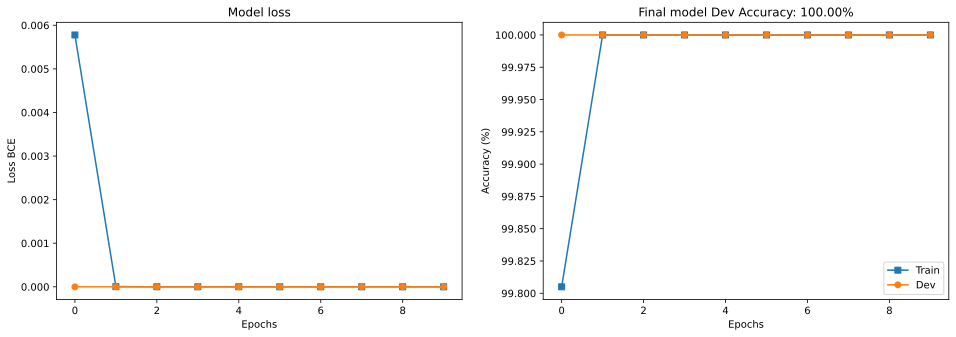

In [176]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))

ax[0].plot(trainLoss.cpu().detach(), "s-", label="Train")
ax[0].plot(testLoss.cpu().detach(), "o-", label="Test")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss BCE")
ax[0].set_title("Model loss")

ax[1].plot(trainAcc.cpu().detach(), "s-", label="Train")
ax[1].plot(devAcc.cpu().detach(), "o-", label="Dev")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy (%)")
ax[1].set_title(f"Final model Dev Accuracy: {devAcc[-1].cpu().detach():.2f}%")
ax[1].legend()

plt.show()

In [177]:
devAcc
trainAcc

tensor([ 99.8050, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000, 100.0000,
        100.0000, 100.0000, 100.0000], device='cuda:0')

In [207]:
# Test Accuracy
net.eval()
with torch.no_grad():
    yHat = net(test_images)
test_labels = torch.squeeze((yHat > 0).float()).cpu()
test_labels

tensor([0., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

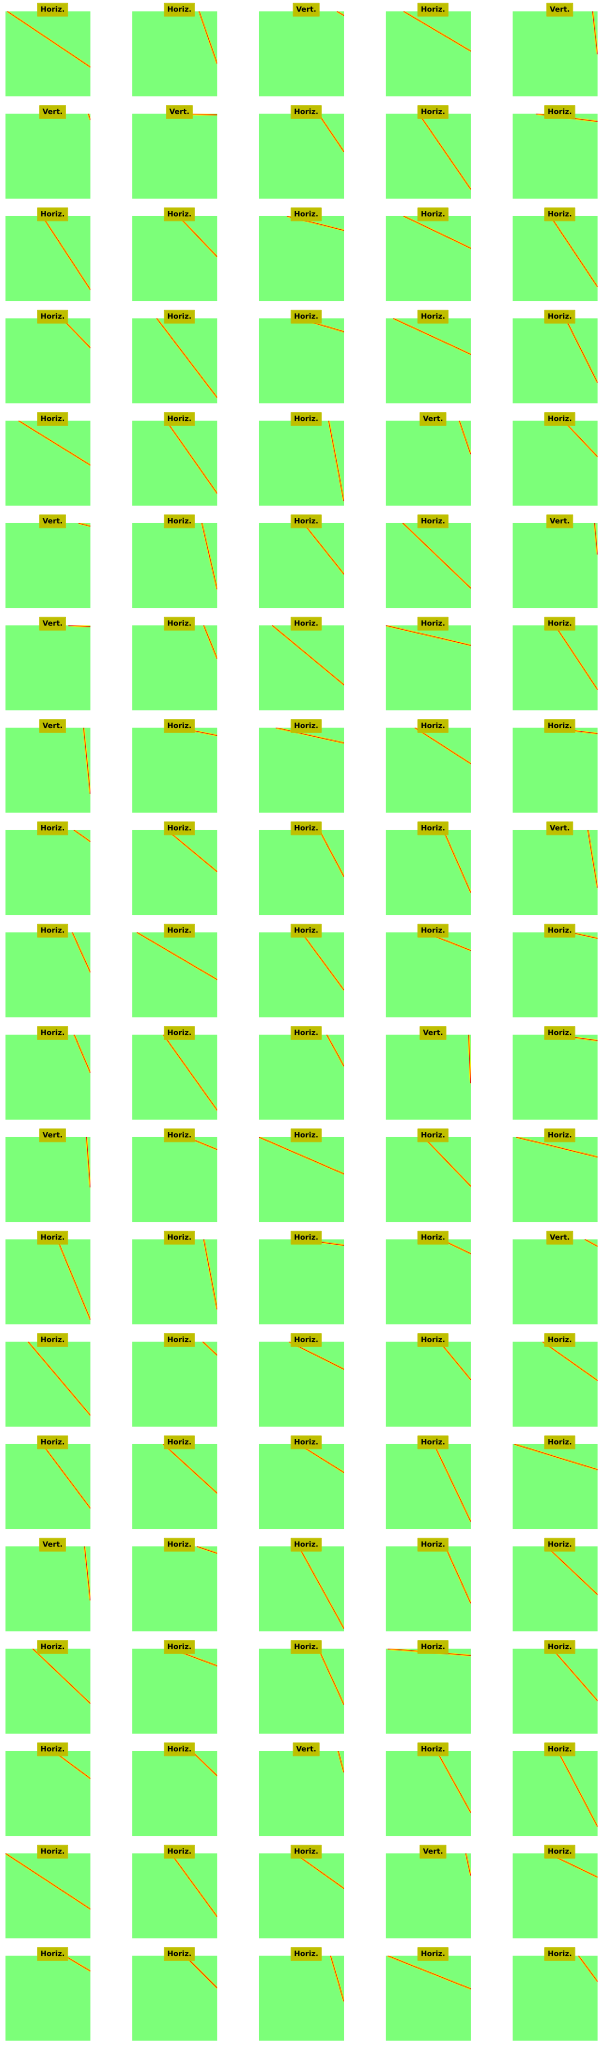

In [208]:
# visualize some test images
fig, axs = plt.subplots(20, 5 , figsize=(15, 50))

for i, ax in enumerate(axs.flatten()):
    label = classes[int(test_labels[i])]
    G = np.squeeze(test_images[i, :, :])
    ax.imshow(G.cpu(), vmin=-1, vmax=1, cmap="jet", label=label)
    ax.text(
        50, 0, label, ha="center", fontweight="bold", color="k", backgroundcolor="y"
    )
    ax.axis("off")
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()